In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel

%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [3]:
X_train = pd.read_csv('./data/X_train.csv', header=None)
T_train = pd.read_csv('./data/T_train.csv', header=None)

In [4]:
X_train_df = pd.DataFrame(X_train.values)
X_train_df['lbl'] = T_train.values
X_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,lbl
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [5]:
# calculate means for each class
mean_class = np.zeros((5, 784))
for i in range(1, 6):
    grouped = X_train_df[X_train_df['lbl'] == i].drop(labels='lbl', axis='columns')
    mean_class[i-1] = grouped.values.mean(axis=0)
mean_class.shape

(5, 784)

In [6]:
# calculate total mean
mean_total = X_train_df.drop(labels='lbl', axis='columns').values.mean(axis=0)
mean_total.shape

(784,)

In [7]:
# calculate between class covariance matrix
# S_B = \sigma{N_i (m_i - m) (m_i - m).T}
S_B = np.zeros((X_train_df.values.shape[1] - 1, X_train_df.values.shape[1] - 1))
for i in range(1, 6):
    N_i = X_train_df[X_train_df['lbl'] == i].drop(labels='lbl', axis='columns').shape[0]
    S_B += N_i * np.outer((mean_class[i-1] - mean_total), (mean_class[i-1] - mean_total))
S_B

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
# calculate within class covariance matrix
# S_W = \sigma{S_i}
# S_i = \sigma{(x - m_i) (x - m_i).T}
S_W = np.zeros(S_B.shape)
for i in range(1, 6):
    grouped = X_train_df[X_train_df['lbl'] == i].drop(labels='lbl', axis='columns')
    tmp = grouped.values - np.expand_dims(mean_class[i-1], axis=0)
    S_W = S_W + np.dot(tmp.T, tmp)
S_W

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
S_B.shape

(784, 784)

In [10]:
S_W.shape

(784, 784)

In [11]:
# objective : find eigenvalue, eigenvector pairs for inv(S_W).S_B
mat = np.dot(np.linalg.pinv(S_W), S_B)
val, vec = np.linalg.eig(mat)
idx = np.argsort(val)[-1: -(2+1): -1]
W = vec[:, idx]
W.shape

(784, 2)

In [12]:
new_X = X_train.values @ W
new_X.shape

(5000, 2)

In [14]:
df = pd.DataFrame(new_X.real, columns=['x', 'y'])
df['target'] = T_train.values
df.head()

,x,y,target
0,-0.012909,-0.006563,1
1,-0.010244,-0.008735,1
2,-0.006978,-0.006139,1
3,-0.012324,-0.008763,1
4,-0.013671,-0.011412,1


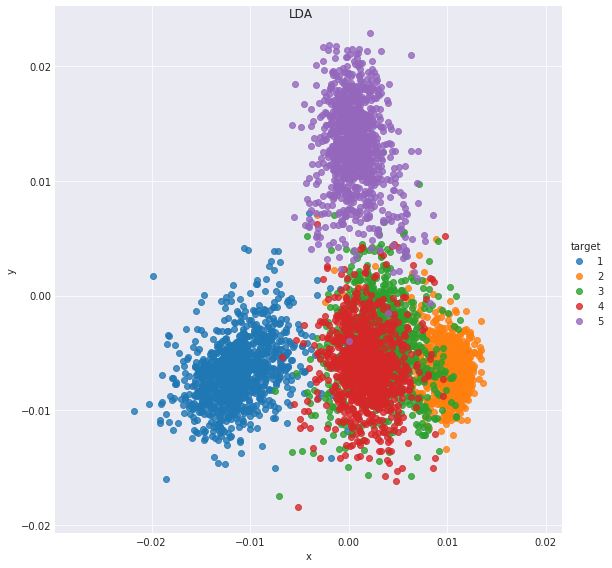

In [15]:
plot = sns.lmplot(x='x', y='y', data=df, fit_reg=False, hue='target', legend=True, size=8)
fig = plot.fig
fig.suptitle("LDA", fontsize=12)
fig.savefig('./plot/{}.png'.format('lda'))